# Machine Learning Models Applied to the IDS-2017

The purpose of this notebook is to experiment different machine learning on the IDS-2017 dataset generated by the CICFlowMeter on the recorder traffic which included benign and malicious flows

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, average_precision_score, make_scorer, precision_score, accuracy_score, confusion_matrix
from notebook_utils import upsample_dataset
%matplotlib inline
%load_ext autoreload
%autoreload 2
file_path = r"..\CIC-IDS-2017\CSVs\GeneratedLabelledFlows\TrafficLabelling\processed\ids2017_processed.csv"

def replace_invalid(df):
    
    # Select only numeric columns
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    
    # Identify columns with NaN, infinity, or negative values
    invalid_columns = df[numeric_columns].columns[df[numeric_columns].isna().any() |
                                                  np.isinf(df[numeric_columns]).any() |
                                                  (df[numeric_columns] < 0).any()]

    print("Columns with NaN, infinity, or negative values:", invalid_columns.tolist())
  
    # Replace invalid values with NaN and fill with column mean
    df[invalid_columns] = df[invalid_columns].replace([np.inf, -np.inf, -1], np.nan)
    df[invalid_columns] = df[invalid_columns].fillna(df[invalid_columns].mean())
    return df
    
def load_dataset(file_path):
    df = pd.read_csv(file_path)
    convert_dict = {'label': 'category'}
    df = df.astype(convert_dict)
    replace_invalid(df)
    df.info()
    return df

attack_labels = {
    0: 'BENIGN',
    7: 'FTP-Patator',
    11: 'SSH-Patator',
    6: 'DoS slowloris',
    5: 'DoS Slowhttptest',
    4: 'DoS Hulk',
    3: 'DoS GoldenEye',
    8: 'Heartbleed',
    12: 'Web Attack - Brute Force',
    14: 'Web Attack - XSS',
    13: 'Web Attack - Sql Injection',
    9: 'Infiltration',
    1: 'Bot',
    10: 'PortScan',
    2: 'DDoS'
}

# 1. Preparing the Dataset

In [2]:
df = load_dataset(file_path)

Columns with NaN, infinity, or negative values: ['flow_duration', 'flow_bytes_s', 'flow_packets_s', 'flow_iat_mean', 'flow_iat_max', 'flow_iat_min', 'fwd_iat_min', 'fwd_header_length', 'bwd_header_length', 'fwd_header_length_1', 'init_win_bytes_forward', 'init_win_bytes_backward', 'min_seg_size_forward']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 96 columns):
 #   Column                       Dtype   
---  ------                       -----   
 0   destination_port             int64   
 1   protocol                     int64   
 2   flow_duration                float64 
 3   total_fwd_packets            int64   
 4   total_backward_packets       int64   
 5   total_length_of_fwd_packets  float64 
 6   total_length_of_bwd_packets  float64 
 7   fwd_packet_length_max        float64 
 8   fwd_packet_length_min        float64 
 9   fwd_packet_length_mean       float64 
 10  fwd_packet_length_std        float64 
 11  bwd_packet_length

In [3]:
X = df.iloc[:, 0:79]
Y = df.iloc[:, 79:]
X.info()
Y.info()
print(Y.label.value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 79 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   destination_port             int64  
 1   protocol                     int64  
 2   flow_duration                float64
 3   total_fwd_packets            int64  
 4   total_backward_packets       int64  
 5   total_length_of_fwd_packets  float64
 6   total_length_of_bwd_packets  float64
 7   fwd_packet_length_max        float64
 8   fwd_packet_length_min        float64
 9   fwd_packet_length_mean       float64
 10  fwd_packet_length_std        float64
 11  bwd_packet_length_max        float64
 12  bwd_packet_length_min        float64
 13  bwd_packet_length_mean       float64
 14  bwd_packet_length_std        float64
 15  flow_bytes_s                 float64
 16  flow_packets_s               float64
 17  flow_iat_mean                float64
 18  flow_iat_std                 float64
 19  

# 2. Feature Selection

### Correlation based feature selection

First, the columns with no variance are dropped as they have no impact on the target variables.

In [4]:
stats = X.describe()
std = stats.loc["std"]
features_no_var = std[std == 0.0].index
# Exclude non-numeric columns (e.g., categorical columns) from the features with zero variance
features_no_var_numeric = [col for col in features_no_var if col in X.select_dtypes(include=[np.number]).columns]
print(features_no_var_numeric)

['bwd_psh_flags', 'bwd_urg_flags', 'fwd_avg_bytes_bulk', 'fwd_avg_packets_bulk', 'fwd_avg_bulk_rate', 'bwd_avg_bytes_bulk', 'bwd_avg_packets_bulk', 'bwd_avg_bulk_rate']


The destination port feature is dropped because it can act as a shortcut predictor and cause high overfitting for the training set as show in this [paper](https://link.springer.com/chapter/10.1007/978-3-031-09484-2_2)

In [5]:
X = X.drop(columns=features_no_var)
X = X.drop(columns=['destination_port'])
columns_to_drop = ['init_win_bytes_forward', 'init_win_bytes_backward']
X = X.drop(columns=columns_to_drop)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 68 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   protocol                     int64  
 1   flow_duration                float64
 2   total_fwd_packets            int64  
 3   total_backward_packets       int64  
 4   total_length_of_fwd_packets  float64
 5   total_length_of_bwd_packets  float64
 6   fwd_packet_length_max        float64
 7   fwd_packet_length_min        float64
 8   fwd_packet_length_mean       float64
 9   fwd_packet_length_std        float64
 10  bwd_packet_length_max        float64
 11  bwd_packet_length_min        float64
 12  bwd_packet_length_mean       float64
 13  bwd_packet_length_std        float64
 14  flow_bytes_s                 float64
 15  flow_packets_s               float64
 16  flow_iat_mean                float64
 17  flow_iat_std                 float64
 18  flow_iat_max                 float64
 19  

### Remove collinear variables

In [6]:
threshold = 0.9
corr_matrix = X.corr().abs()
corr_matrix.head()

,protocol,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min
protocol,1.000000,0.265288,0.007272,0.006361,0.033234,0.005191,0.166066,0.315250,0.052344,0.178832,...,0.005043,0.003451,0.085598,0.081018,0.109356,0.063663,0.179676,0.071305,0.184514,0.170531
flow_duration,0.265288,1.000000,0.020857,0.019669,0.065456,0.016186,0.273304,0.105235,0.143685,0.234434,...,0.015942,0.001357,0.189298,0.241059,0.294033,0.121169,0.768031,0.243153,0.779524,0.738325
total_fwd_packets,0.007272,0.020857,1.000000,0.999070,0.365508,0.996993,0.009358,0.002989,0.000032,0.001403,...,0.887387,0.000184,0.039937,0.008329,0.030459,0.041283,0.001820,0.000809,0.001906,0.001670
total_backward_packets,0.006361,0.019669,0.999070,1.000000,0.359451,0.994429,0.009039,0.002600,0.000333,0.001026,...,0.882566,0.000018,0.038963,0.006437,0.028602,0.041278,0.001425,0.000492,0.001456,0.001330
total_length_of_fwd_packets,0.033234,0.065456,0.365508,0.359451,1.000000,0.353762,0.197030,0.000275,0.185262,0.159787,...,0.407448,0.001209,0.101084,0.103326,0.126493,0.068325,0.022660,0.027064,0.026079,0.018634


In [7]:
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
upper.head()

,protocol,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min
protocol,NaN,0.265288,0.007272,0.006361,0.033234,0.005191,0.166066,0.315250,0.052344,0.178832,...,0.005043,0.003451,0.085598,0.081018,0.109356,0.063663,0.179676,0.071305,0.184514,0.170531
flow_duration,NaN,NaN,0.020857,0.019669,0.065456,0.016186,0.273304,0.105235,0.143685,0.234434,...,0.015942,0.001357,0.189298,0.241059,0.294033,0.121169,0.768031,0.243153,0.779524,0.738325
total_fwd_packets,NaN,NaN,NaN,0.999070,0.365508,0.996993,0.009358,0.002989,0.000032,0.001403,...,0.887387,0.000184,0.039937,0.008329,0.030459,0.041283,0.001820,0.000809,0.001906,0.001670
total_backward_packets,NaN,NaN,NaN,NaN,0.359451,0.994429,0.009039,0.002600,0.000333,0.001026,...,0.882566,0.000018,0.038963,0.006437,0.028602,0.041278,0.001425,0.000492,0.001456,0.001330
total_length_of_fwd_packets,NaN,NaN,NaN,NaN,NaN,0.353762,0.197030,0.000275,0.185262,0.159787,...,0.407448,0.001209,0.101084,0.103326,0.126493,0.068325,0.022660,0.027064,0.026079,0.018634


In [8]:
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
to_keep = [
    'Destination Port', 'Fwd Packet Length Std', 'Min Packet Length', 
    'Packet Length Variance', 'PSH Flag Count', 'Active Max'
]
to_drop = [column for column in to_drop if column not in to_keep]
print('There are %d columns to remove.' % (len(to_drop)))
X = X.drop(columns=to_drop)
X.info()

There are 31 columns to remove.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 37 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   protocol                     int64  
 1   flow_duration                float64
 2   total_fwd_packets            int64  
 3   total_length_of_fwd_packets  float64
 4   fwd_packet_length_max        float64
 5   fwd_packet_length_min        float64
 6   fwd_packet_length_mean       float64
 7   bwd_packet_length_max        float64
 8   bwd_packet_length_min        float64
 9   flow_bytes_s                 float64
 10  flow_packets_s               float64
 11  flow_iat_mean                float64
 12  flow_iat_std                 float64
 13  flow_iat_min                 float64
 14  fwd_iat_min                  float64
 15  bwd_iat_total                float64
 16  bwd_iat_mean                 float64
 17  bwd_iat_std                  float64
 18  bwd_iat_ma

### 3. Split Dataset

The dataset is split into a train, cross-validation and evaluation sets with a ratio of 0.8/0.1/0.1. The dataset is stratified according to the label to have an equal representation of all classes in the 3 subsets.

In [9]:
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.2, stratify=Y.label_code)
X_eval, X_test, Y_eval, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, stratify=Y_temp.label_code)

Upsampling is used to generate artificial samples for types of attacks that are underrepresented in the dataset.

In [10]:
X_train, Y_train = upsample_dataset(X_train, Y_train, 100000, attack_labels)

In [11]:
Y_train.label.value_counts()

label
BENIGN                        1818477
DoS Hulk                       184858
PortScan                       127144
DDoS                           102421
Bot                            100000
DoS GoldenEye                  100000
DoS Slowhttptest               100000
DoS slowloris                  100000
FTP-Patator                    100000
Heartbleed                     100000
Infiltration                   100000
SSH-Patator                    100000
Web Attack - Brute Force       100000
Web Attack - Sql Injection     100000
Web Attack - XSS               100000
Name: count, dtype: int64

In [12]:
Y_eval.label.value_counts()

label
BENIGN                        227310
DoS Hulk                       23107
PortScan                       15893
DDoS                           12803
DoS GoldenEye                   1029
FTP-Patator                      794
SSH-Patator                      589
DoS slowloris                    579
DoS Slowhttptest                 550
Bot                              197
Web Attack - Brute Force         151
Web Attack - XSS                  65
Infiltration                       4
Web Attack - Sql Injection         2
Heartbleed                         1
Name: count, dtype: int64

In [13]:
Y_test.label.value_counts()

label
BENIGN                        227310
DoS Hulk                       23108
PortScan                       15893
DDoS                           12803
DoS GoldenEye                   1030
FTP-Patator                      794
SSH-Patator                      590
DoS slowloris                    580
DoS Slowhttptest                 550
Bot                              196
Web Attack - Brute Force         150
Web Attack - XSS                  65
Infiltration                       3
Web Attack - Sql Injection         2
Heartbleed                         1
Name: count, dtype: int64

Statistics for the training set

In [14]:
benign_percentage = len(Y_train.label[Y_train["label"]=="BENIGN"])/len(Y_train)
print('Percentage of benign samples: %.4f' % benign_percentage)
print(Y_train.is_attack.value_counts())

Percentage of benign samples: 0.5456
is_attack
0.0    1818477
1.0    1514423
Name: count, dtype: int64


# 3. Machine Learning Classifiers

In this section, different machine learning models are applied to classify network traffic. The metrics used to evaluate the models are primarily accuracy, precision, recall and the F1 score.

In [15]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [16]:
def plot_confusion_matrix(model_name, Y_true, Y_pred, labels=["Benign", "Attack"]):
    matrix = confusion_matrix(Y_true.is_attack, Y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

def metrics_report(dataset_type, y_true, y_predict, print_avg=True):
    print(f"Classification Report ({dataset_type}):")
    print(classification_report(y_true, y_predict, digits=4))
    if print_avg:
        print(f"Avg Precision Score: {average_precision_score(y_true, y_predict, average='weighted')}")
    print("Accuracy:",accuracy_score(y_true, y_predict))
    res = classification_report(y_true, y_predict, digits=4, output_dict = True)
    res["accuracy"] = accuracy_score(y_true, y_predict)
    return res

In [17]:
performance_models = {}

#### Functions for saving and loading modules

In [18]:
import joblib

def save_model(model, model_name):
    file_path = f'models/{model_name}.pkl'
    joblib.dump(model, file_path)
    print(f'Model saved to {file_path}')

def load_model(model_name):
    file_path = f'models/{model_name}.pkl'
    model = joblib.load(file_path)
    print(f'Model loaded from {file_path}')
    return model

os.makedirs('models', exist_ok=True)

## 3.1 Decision Trees/Ensembles Algorithms

### 3.1.1 Random Forest

#### Binary Classification

In [19]:
rf_model_binary = RandomForestClassifier(verbose=1, n_jobs=-1, class_weight='balanced', criterion="entropy", n_estimators = 300, bootstrap = True, max_features=None)
rf_model_binary.fit(scaler.transform(X_train), Y_train.is_attack)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed: 21.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 36.1min finished


RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_features=None, n_estimators=300, n_jobs=-1,
                       verbose=1)

Evaluation Set Performance


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    0.8s finished


Classification Report (Evaluation):
              precision    recall  f1-score   support

           0     0.9974    0.9689    0.9829    227310
           1     0.8863    0.9898    0.9352     55764

    accuracy                         0.9730    283074
   macro avg     0.9419    0.9793    0.9591    283074
weighted avg     0.9755    0.9730    0.9735    283074

Avg Precision Score: 0.8792910572211612
Accuracy: 0.9729823297088394
Test Set Performance


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    0.8s finished


Classification Report (Test):
              precision    recall  f1-score   support

           0     0.9972    0.9687    0.9827    227310
           1     0.8856    0.9889    0.9344     55765

    accuracy                         0.9727    283075
   macro avg     0.9414    0.9788    0.9586    283075
weighted avg     0.9752    0.9727    0.9732    283075

Avg Precision Score: 0.8779653133926634
Accuracy: 0.9726503576790603


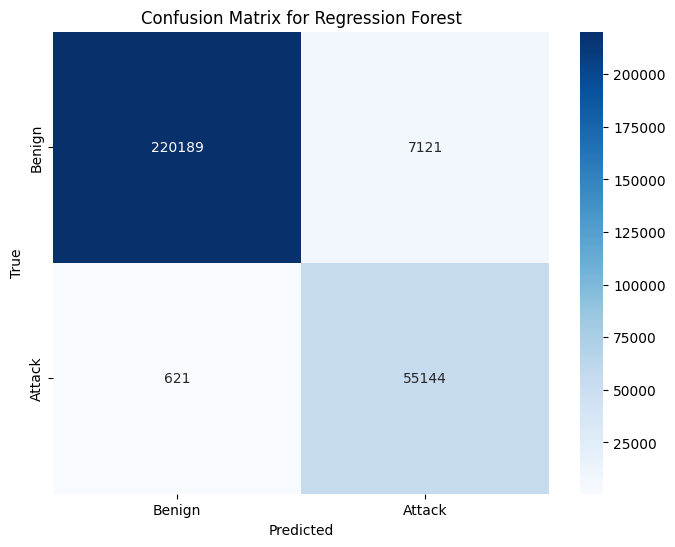

In [20]:
print("Evaluation Set Performance")
metrics_report("Evaluation", Y_eval.is_attack, rf_model_binary.predict(scaler.transform(X_eval)))
# Predict and evaluate on the test set
print("Test Set Performance")
Y_pred = rf_model_binary.predict(scaler.transform(X_test))
performance_models["rf"] = metrics_report("Test", Y_test.is_attack, Y_pred)
plot_confusion_matrix("Regression Forest", Y_test, Y_pred)

#### Multi-class classifier

In [21]:
rf_model_multiclass = RandomForestClassifier(verbose=1, n_jobs=-1, class_weight='balanced')
rf_model_multiclass.fit(scaler.transform(X_train), Y_train.label_code)
# Predict and evaluate on the evaluation set
print("Evaluation Set Performance")
metrics_report("Evaluation", Y_eval.label_code, rf_model_multiclass.predict(scaler.transform(X_eval)), print_avg=False)
# Predict and evaluate on the test set
print("Test Set Performance")
metrics_report("Test", Y_test.label_code, rf_model_multiclass.predict(scaler.transform(X_test)), print_avg=False)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   53.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.0min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Evaluation Set Performance


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.9s finished


Classification Report (Evaluation):
              precision    recall  f1-score   support

           0     0.9995    0.9299    0.9634    227310
           1     0.0344    0.9695    0.0665       197
           2     0.9989    0.9987    0.9988     12803
           3     0.9688    0.9961    0.9823      1029
           4     0.8914    0.9954    0.9405     23107
           5     0.9493    0.9873    0.9679       550
           6     0.9948    0.9896    0.9922       579
           7     0.9382    0.9950    0.9658       794
           8     1.0000    1.0000    1.0000         1
           9     1.0000    0.5000    0.6667         4
          10     0.9941    0.9998    0.9970     15893
          11     0.1183    0.9117    0.2094       589
          12     0.2833    0.4503    0.3478       151
          13     0.0000    0.0000    0.0000         2
          14     0.0777    0.7077    0.1400        65

    accuracy                         0.9426    283074
   macro avg     0.6833    0.8287    0.6826 

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.9s finished


Classification Report (Test):
              precision    recall  f1-score   support

           0     0.9995    0.9298    0.9634    227310
           1     0.0335    0.9643    0.0648       196
           2     0.9984    0.9990    0.9987     12803
           3     0.9634    0.9971    0.9800      1030
           4     0.8886    0.9955    0.9391     23108
           5     0.9349    0.9927    0.9630       550
           6     0.9880    0.9914    0.9897       580
           7     0.9589    1.0000    0.9790       794
           8     1.0000    1.0000    1.0000         1
           9     1.0000    0.6667    0.8000         3
          10     0.9942    0.9996    0.9969     15893
          11     0.1167    0.8915    0.2064       590
          12     0.3080    0.4867    0.3773       150
          13     0.0003    0.5000    0.0007         2
          14     0.0686    0.5692    0.1225        65

    accuracy                         0.9425    283075
   macro avg     0.6836    0.8656    0.6921    283

{'0': {'precision': 0.999527074958619,
  'recall': 0.9297875148475649,
  'f1-score': 0.9633968456559394,
  'support': 227310.0},
 '1': {'precision': 0.03354037267080745,
  'recall': 0.9642857142857143,
  'f1-score': 0.06482593037214886,
  'support': 196.0},
 '2': {'precision': 0.9984387197501952,
  'recall': 0.9989846129813325,
  'f1-score': 0.9987115917698044,
  'support': 12803.0},
 '3': {'precision': 0.9634146341463414,
  'recall': 0.9970873786407767,
  'f1-score': 0.9799618320610687,
  'support': 1030.0},
 '4': {'precision': 0.8886356613102596,
  'recall': 0.99554266920547,
  'f1-score': 0.9390562494897543,
  'support': 23108.0},
 '5': {'precision': 0.934931506849315,
  'recall': 0.9927272727272727,
  'f1-score': 0.9629629629629629,
  'support': 550.0},
 '6': {'precision': 0.9879725085910653,
  'recall': 0.9913793103448276,
  'f1-score': 0.9896729776247849,
  'support': 580.0},
 '7': {'precision': 0.9589371980676329,
  'recall': 1.0,
  'f1-score': 0.9790382244143033,
  'support': 7

Given that the dataset lacks many samples for some of the attack types, the multiclass classifier has low accuracy for several attack types, even after upsampling, which will cause overfitting in this case. It is better to test other machine learning algorithms for binary classifiers.

### 3.1.2 Gradient Boost (XGB)

In [22]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, precision_score

# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0, 0.1, 0.5, 1]
}

# Initialize the XGBoost classifier
xgb_model_binary = xgb.XGBClassifier(objective='binary:logistic', scale_pos_weight=1, n_jobs=-1)

# Define the scorer
scorer = make_scorer(precision_score)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xgb_model_binary, param_distributions=param_grid, n_iter=20,
                                   scoring=scorer, n_jobs=-1, cv=2, verbose=2, random_state=42)

# Fit the model on the training data
random_search.fit(scaler.transform(X_train.astype('float32')), Y_train.is_attack)

# Get the best model
best_xgb_model = random_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)

Fitting 2 folds for each of 20 candidates, totalling 40 fits
Best Hyperparameters: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.2, 'gamma': 0.3, 'colsample_bytree': 0.8}


Best Hyperparameters: {'subsample': 1.0, 'reg_lambda': 0, 'reg_alpha': 0.5, 'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.6}

In [23]:
best_params = random_search.best_params_

best_xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=1,
    n_jobs=-1,
    **best_params
)

# Fit the model on the training data
best_xgb_model.fit(scaler.transform(X_train), Y_train.is_attack)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.3, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

Evaluation Set Performance
Classification Report (Evaluation):
              precision    recall  f1-score   support

           0     0.9972    0.9708    0.9838    227310
           1     0.8924    0.9887    0.9381     55764

    accuracy                         0.9743    283074
   macro avg     0.9448    0.9798    0.9610    283074
weighted avg     0.9765    0.9743    0.9748    283074

Accuracy: 0.9743035390039354
Test Set Performance
Classification Report (Test):
              precision    recall  f1-score   support

           0     0.9968    0.9706    0.9835    227310
           1     0.8919    0.9873    0.9372     55765

    accuracy                         0.9739    283075
   macro avg     0.9443    0.9790    0.9604    283075
weighted avg     0.9761    0.9739    0.9744    283075

Accuracy: 0.9739185728163914


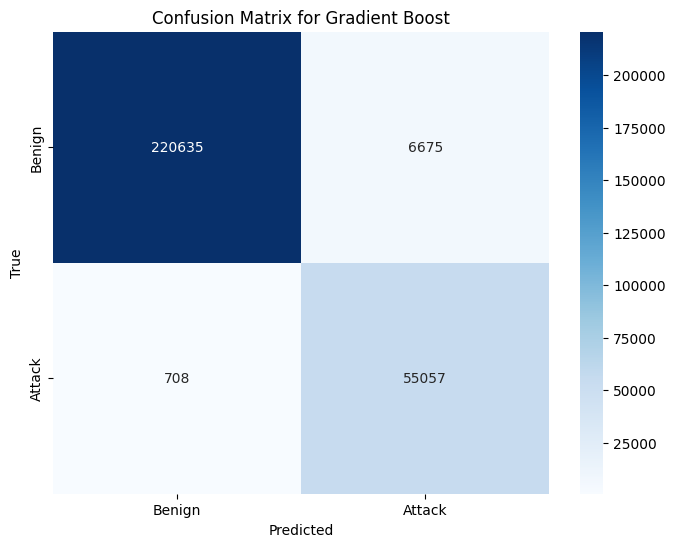

In [24]:
# Predict and evaluate on the evaluation set
print("Evaluation Set Performance")
metrics_report("Evaluation", Y_eval.is_attack, best_xgb_model.predict(scaler.transform(X_eval)), print_avg=False)
# Predict and evaluate on the test set
print("Test Set Performance")
Y_pred = best_xgb_model.predict(scaler.transform(X_test))
performance_models["xgb"] = metrics_report("Test", Y_test.is_attack, Y_pred, print_avg=False)
plot_confusion_matrix("Gradient Boost", Y_test, Y_pred)


### 3.1.3 ADABoost

In [25]:
from sklearn.ensemble import AdaBoostClassifier
ada_boost_model = AdaBoostClassifier(
    n_estimators=50,  # Number of weak learners
    learning_rate=1.0,  # Learning rate (contribution of each weak learner)
    algorithm='SAMME',  # SAMME.R is recommended for probability estimates
    random_state=42
)

# Fit the model on the training data
ada_boost_model.fit(scaler.transform(X_train), Y_train.is_attack)

AdaBoostClassifier(algorithm='SAMME', random_state=42)

Classification Report (Evaluation):
              precision    recall  f1-score   support

           0     0.9898    0.8536    0.9167    227310
           1     0.6177    0.9642    0.7530     55764

    accuracy                         0.8754    283074
   macro avg     0.8037    0.9089    0.8348    283074
weighted avg     0.9165    0.8754    0.8844    283074

Accuracy: 0.8753647456142211
Classification Report (Test):
              precision    recall  f1-score   support

           0     0.9898    0.8538    0.9168    227310
           1     0.6181    0.9642    0.7533     55765

    accuracy                         0.8756    283075
   macro avg     0.8039    0.9090    0.8350    283075
weighted avg     0.9166    0.8756    0.8846    283075

Accuracy: 0.8755665459683829


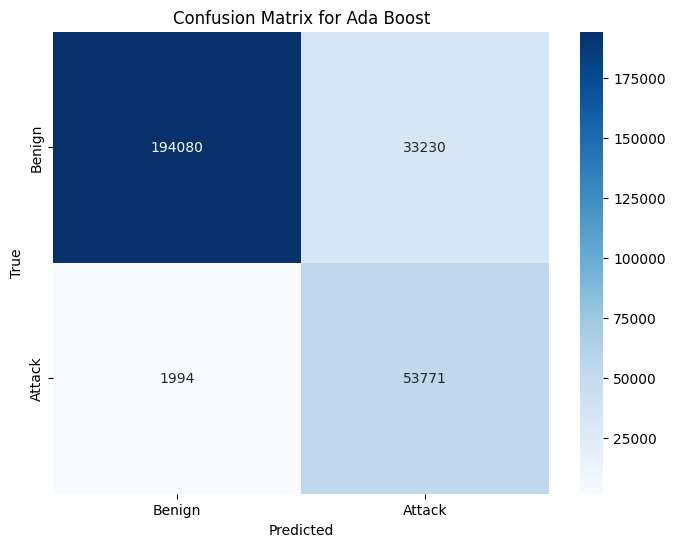

In [26]:
# Predict and evaluate on the evaluation set
y_pred_eval = ada_boost_model.predict(scaler.transform(X_eval))
metrics_report("Evaluation", Y_eval.is_attack, y_pred_eval, print_avg=False)

# Predict and evaluate on the test set
y_pred_test = ada_boost_model.predict(scaler.transform(X_test))
performance_models["adaboost"] = metrics_report("Test", Y_test.is_attack, y_pred_test, print_avg=False)
plot_confusion_matrix("Ada Boost", Y_test, y_pred_test)

### 3.1.4 ID3

In [27]:
id3_model = DecisionTreeClassifier(
    criterion='entropy',  # Use entropy for ID3-like behavior
    max_depth=None,  # Unlimited depth (ID3 doesn't prune trees)
    random_state=42
)

# Fit the model on the training data
id3_model.fit(scaler.transform(X_train), Y_train.is_attack)

DecisionTreeClassifier(criterion='entropy', random_state=42)

Classification Report (Evaluation):
              precision    recall  f1-score   support

           0     0.9968    0.9735    0.9850    227310
           1     0.9015    0.9873    0.9425     55764

    accuracy                         0.9763    283074
   macro avg     0.9492    0.9804    0.9638    283074
weighted avg     0.9780    0.9763    0.9767    283074

Accuracy: 0.9762570917851869
Classification Report (Test):
              precision    recall  f1-score   support

           0     0.9966    0.9735    0.9849    227310
           1     0.9012    0.9864    0.9418     55765

    accuracy                         0.9760    283075
   macro avg     0.9489    0.9799    0.9634    283075
weighted avg     0.9778    0.9760    0.9764    283075

Accuracy: 0.9759992934734611


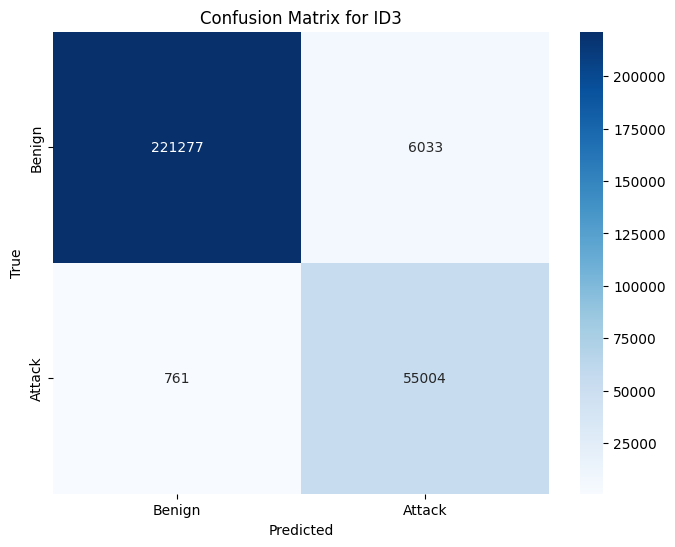

In [28]:
y_pred_eval = id3_model.predict(scaler.transform(X_eval))
metrics_report("Evaluation", Y_eval.is_attack, y_pred_eval, print_avg=False)

# Predict and evaluate on the test set
y_pred_test = id3_model.predict(scaler.transform(X_test))
performance_models["id3"] = metrics_report("Test", Y_test.is_attack, y_pred_test, print_avg=False)
plot_confusion_matrix("ID3", Y_test, y_pred_test)

In [29]:
save_model(id3_model, 'id3_model')

Model saved to models/id3_model.pkl


### Conclusion

[0.9726503576790603, 0.9739185728163914, 0.8755665459683829, 0.9759992934734611]
['rf', 'xgb', 'adaboost', 'id3']


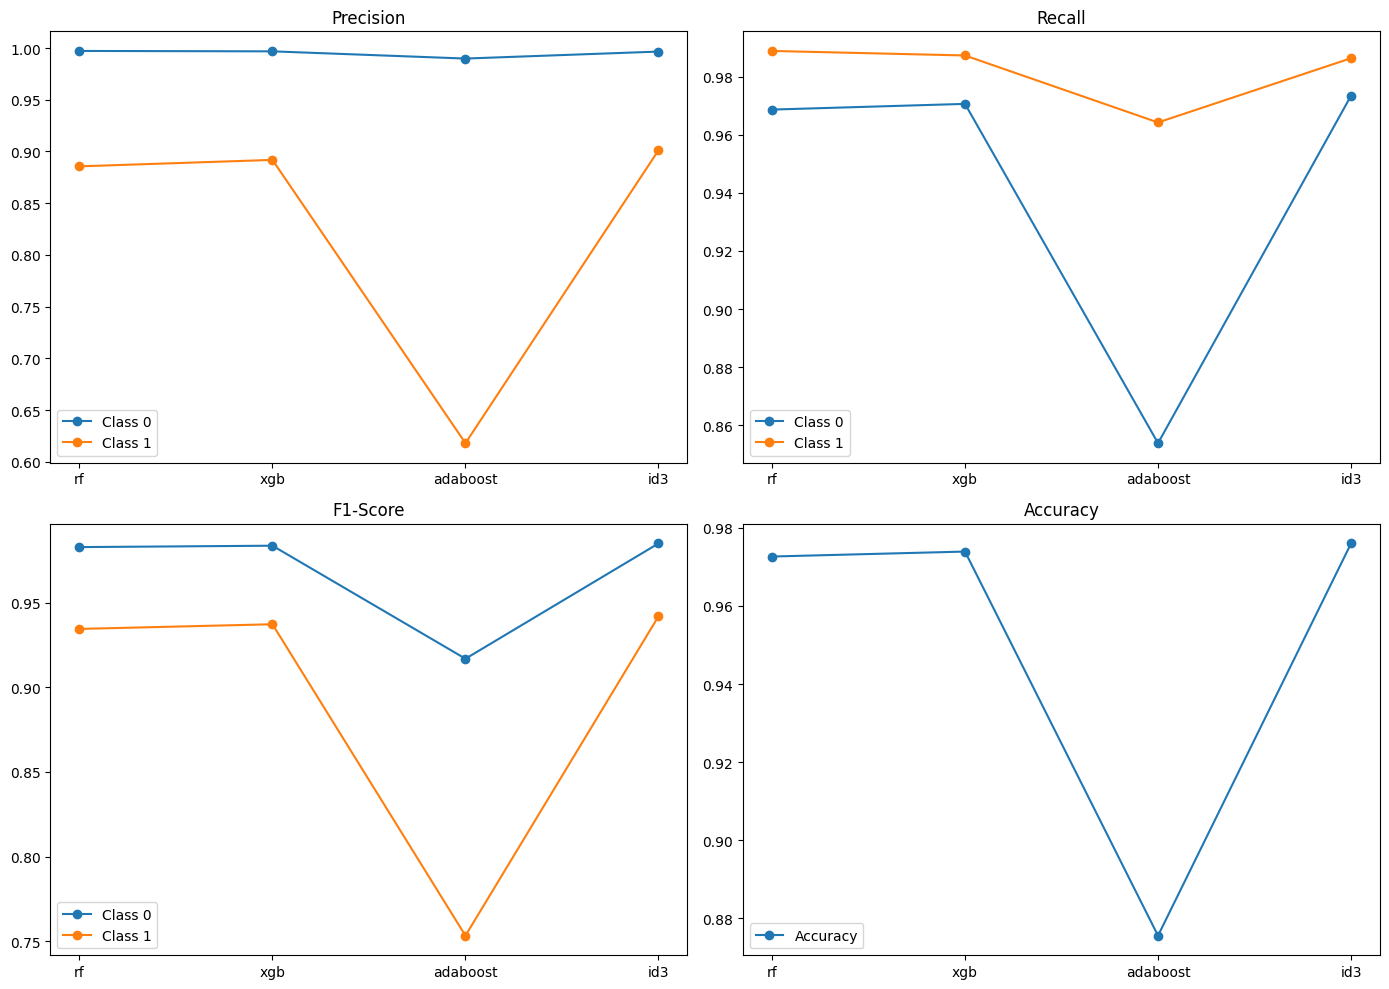

In [30]:
def extract_and_plot_metrics(metrics_dict):
    # Initialize dictionaries to store the metrics for plotting
    precision_dict = {'0': [], '1': [], 'model': []}
    recall_dict = {'0': [], '1': [], 'model': []}
    f1_score_dict = {'0': [], '1': [], 'model': []}
    accuracy_list = []

    # Iterate over the models in the metrics dictionary
    for model_name, metrics in metrics_dict.items():
        precision_dict['0'].append(metrics['0']['precision'])
        precision_dict['1'].append(metrics['1']['precision'])
        recall_dict['0'].append(metrics['0']['recall'])
        recall_dict['1'].append(metrics['1']['recall'])
        f1_score_dict['0'].append(metrics['0']['f1-score'])
        f1_score_dict['1'].append(metrics['1']['f1-score'])
        accuracy_list.append(metrics['accuracy'])
        precision_dict['model'].append(model_name)
        recall_dict['model'].append(model_name)
        f1_score_dict['model'].append(model_name)
        
    # Plotting the metrics
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot precision
    axs[0, 0].plot(precision_dict['model'], precision_dict['0'], label='Class 0', marker='o')
    axs[0, 0].plot(precision_dict['model'], precision_dict['1'], label='Class 1', marker='o')
    axs[0, 0].set_title('Precision')
    axs[0, 0].legend()
    
    # Plot recall
    axs[0, 1].plot(recall_dict['model'], recall_dict['0'], label='Class 0', marker='o')
    axs[0, 1].plot(recall_dict['model'], recall_dict['1'], label='Class 1', marker='o')
    axs[0, 1].set_title('Recall')
    axs[0, 1].legend()
    
    # Plot f1-score
    axs[1, 0].plot(f1_score_dict['model'], f1_score_dict['0'], label='Class 0', marker='o')
    axs[1, 0].plot(f1_score_dict['model'], f1_score_dict['1'], label='Class 1', marker='o')
    axs[1, 0].set_title('F1-Score')
    axs[1, 0].legend()
    
    # Plot accuracy
    print(accuracy_list)
    print(precision_dict['model'])
    axs[1, 1].plot(precision_dict['model'], accuracy_list, label='Accuracy', marker='o')
    axs[1, 1].set_title('Accuracy')
    axs[1, 1].legend()
    
    plt.tight_layout()
    plt.show()

extract_and_plot_metrics(performance_models)

ID3 and Random Forest perform very well on the dataset while Adaboost is the worst model. To conclude, after finetuning the hyperparameters, random forest seems to be the best tree based algorithm to perform on the dataset. 

## 3.2 Deep Neural Network

In this section, deep neural networks are used to create binary classifiers that distinguish between benign and malicious traffics. Hyperparameters are optimized to obtain the best results.

In [31]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [32]:
# Define the model architecture
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(scaler.transform(X_train).shape[1],)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(scaler.transform(X_train), Y_train.is_attack, epochs=10, batch_size=32, validation_split=0.2)

C:\Users\youss\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
83323/83323 ━━━━━━━━━━━━━━━━━━━━ 66s 784us/step - accuracy: 0.9251 - loss: 0.1959 - val_accuracy: 0.1849 - val_loss: 15.4073
Epoch 2/10
83323/83323 ━━━━━━━━━━━━━━━━━━━━ 85s 1ms/step - accuracy: 0.9449 - loss: 0.1371 - val_accuracy: 0.1839 - val_loss: 19.2662
Epoch 3/10
83323/83323 ━━━━━━━━━━━━━━━━━━━━ 96s 1ms/step - accuracy: 0.9475 - loss: 0.1310 - val_accuracy: 0.2258 - val_loss: 8.2055
Epoch 4/10
83323/83323 ━━━━━━━━━━━━━━━━━━━━ 116s 1ms/step - accuracy: 0.9482 - loss: 0.1425 - val_accuracy: 0.1937 - val_loss: 11.6141
Epoch 5/10
83323/83323 ━━━━━━━━━━━━━━━━━━━━ 96s 1ms/step - accuracy: 0.9492 - loss: 0.1220 - val_accuracy: 0.2019 - val_loss: 11.3310
Epoch 6/10
83323/83323 ━━━━━━━━━━━━━━━━━━━━ 100s 1ms/step - accuracy: 0.9498 - loss: 0.1222 - val_accuracy: 0.2057 - val_loss: 12.1764
Epoch 7/10
83323/83323 ━━━━━━━━━━━━━━━━━━━━ 93s 1ms/step - accuracy: 0.9503 - loss: 0.1628 - val_accuracy: 0.1997 - val_loss: 12.1042
Epoch 8/10
83323/83323 ━━━━━━━━━━━━━━━━━━━━ 105s 1ms/step -

8847/8847 ━━━━━━━━━━━━━━━━━━━━ 4s 423us/step
Classification Report (Evaluation):
              precision    recall  f1-score   support

           0     0.9859    0.9594    0.9724    227310
           1     0.8507    0.9440    0.8950     55764

    accuracy                         0.9563    283074
   macro avg     0.9183    0.9517    0.9337    283074
weighted avg     0.9593    0.9563    0.9572    283074

Accuracy: 0.9563471035842218
8847/8847 ━━━━━━━━━━━━━━━━━━━━ 4s 417us/step
Classification Report (Test):
              precision    recall  f1-score   support

           0     0.9856    0.9590    0.9721    227310
           1     0.8494    0.9430    0.8938     55765

    accuracy                         0.9558    283075
   macro avg     0.9175    0.9510    0.9329    283075
weighted avg     0.9588    0.9558    0.9567    283075

Accuracy: 0.9558350260531662


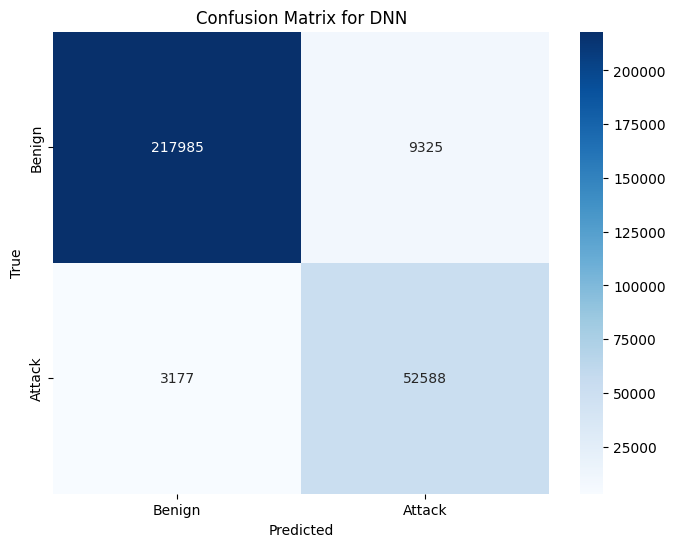

In [33]:
# Predict probabilities on the evaluation set
y_pred_eval_prob = model.predict(scaler.transform(X_eval))
# Convert probabilities to binary predictions
y_pred_eval = (y_pred_eval_prob > 0.5).astype(int)
metrics_report("Evaluation", Y_eval.is_attack, y_pred_eval, print_avg=False)

# Predict and evaluate on the test set
y_pred_test_prob = model.predict(scaler.transform(X_test))
y_pred_test = (y_pred_test_prob > 0.5).astype(int)

metrics_report("Test", Y_test.is_attack, y_pred_test, print_avg=False)
plot_confusion_matrix("DNN", Y_test, y_pred_test)

### Hyperparameter Tuning

In [34]:
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_input', min_value=32, max_value=512, step=32), activation='relu', input_shape=(X_train.shape[1],)))
    
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=512, step=32), activation='relu'))
        model.add(Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.1)))
    
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default=1e-3)),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [35]:
from keras_tuner import RandomSearch

directory_path = os.path.join(os.getcwd(), 'hyperparam_tuning')
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory=directory_path,
    project_name='intrusion_detection'
)

tuner.search_space_summary()

# Perform the search
tuner.search(scaler.transform(X_train), Y_train.is_attack, epochs=10, validation_split=0.2)

Trial 10 Complete [00h 22m 41s]
val_accuracy: 0.431711882352829

Best val_accuracy So Far: 0.4922575056552887
Total elapsed time: 05h 45m 02s


In [36]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps)
model1 = build_model(best_hps)
history = model.fit(scaler.transform(X_train), Y_train.is_attack, epochs=20, validation_split=0.2, verbose=1)

C:\Users\youss\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
83323/83323 ━━━━━━━━━━━━━━━━━━━━ 57s 676us/step - accuracy: 0.9517 - loss: 0.1357 - val_accuracy: 0.2551 - val_loss: 5.7427
Epoch 2/20
83323/83323 ━━━━━━━━━━━━━━━━━━━━ 55s 664us/step - accuracy: 0.9521 - loss: 0.1287 - val_accuracy: 0.2041 - val_loss: 10.3793
Epoch 3/20
83323/83323 ━━━━━━━━━━━━━━━━━━━━ 56s 666us/step - accuracy: 0.9521 - loss: 0.1252 - val_accuracy: 0.2543 - val_loss: 10.3243
Epoch 4/20
83323/83323 ━━━━━━━━━━━━━━━━━━━━ 56s 670us/step - accuracy: 0.9519 - loss: 0.1273 - val_accuracy: 0.2437 - val_loss: 9.2029
Epoch 5/20
83323/83323 ━━━━━━━━━━━━━━━━━━━━ 56s 672us/step - accuracy: 0.9518 - loss: 0.2615 - val_accuracy: 0.2678 - val_loss: 8.8133
Epoch 6/20
83323/83323 ━━━━━━━━━━━━━━━━━━━━ 56s 666us/step - accuracy: 0.9521 - loss: 0.1224 - val_accuracy: 0.2514 - val_loss: 8.8271
Epoch 7/20
83323/83323 ━━━━━━━━━━━━━━━━━━━━ 56s 667us/step - accuracy: 0.9522 - loss: 0.1199 - val_accuracy: 0.2370 - val_loss: 7.2187
Epoch 8/20
83323/83323 ━━━━━━━━━━━━━━━━━━━━ 56s 669us

In [37]:
print(best_hps.values)

{'units_input': 384, 'num_layers': 2, 'units_0': 416, 'dropout_0': 0.2, 'learning_rate': 0.0009635513804323065, 'units_1': 224, 'dropout_1': 0.2, 'units_2': 288, 'dropout_2': 0.30000000000000004}


In [38]:
from tensorflow.keras.models import save_model as save_model_keras

def save_keras_model(model, model_name):
    file_path = f'models/{model_name}.h5'
    save_model_keras(model, file_path)
    print(f'Model saved to {file_path}')

# save_keras_model(model, 'DNN_model1')

#### Best Hyperparameters
{'units_input': 480, 'num_layers': 2, 'units_0': 448, 'dropout_0': 0.30000000000000004, 'learning_rate': 0.00614260757976685, 'units_1': 224, 'dropout_1': 0.0, 'units_2': 256, 'dropout_2': 0.4}

8847/8847 ━━━━━━━━━━━━━━━━━━━━ 4s 420us/step
Classification Report (Evaluation):
              precision    recall  f1-score   support

           0     0.9849    0.9657    0.9752    227310
           1     0.8704    0.9396    0.9037     55764

    accuracy                         0.9605    283074
   macro avg     0.9277    0.9526    0.9394    283074
weighted avg     0.9623    0.9605    0.9611    283074

Accuracy: 0.9605438860509973
8847/8847 ━━━━━━━━━━━━━━━━━━━━ 4s 420us/step
Classification Report (Test):
              precision    recall  f1-score   support

           0     0.9847    0.9653    0.9749    227310
           1     0.8692    0.9389    0.9027     55765

    accuracy                         0.9601    283075
   macro avg     0.9269    0.9521    0.9388    283075
weighted avg     0.9620    0.9601    0.9607    283075

Accuracy: 0.9601271747770026


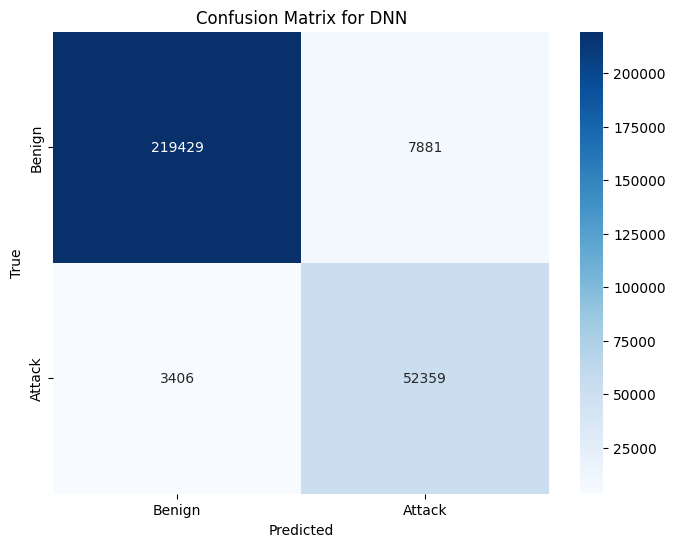

In [39]:
# Predict probabilities on the evaluation set
y_pred_eval_prob = model.predict(scaler.transform(X_eval))
# Convert probabilities to binary predictions
y_pred_eval = (y_pred_eval_prob > 0.5).astype(int)
metrics_report("Evaluation", Y_eval.is_attack, y_pred_eval, print_avg=False)
# Predict and evaluate on the test set
y_pred_test_prob = model.predict(scaler.transform(X_test))
y_pred_test = (y_pred_test_prob > 0.5).astype(int)

metrics_report("Test", Y_test.is_attack, y_pred_test, print_avg=False)
plot_confusion_matrix("DNN", Y_test, y_pred_test)